#### 掩饰利用swot_l2_hr_pixc数据进行湖泊水位信息提取流程，以滇池水位提取为例。
#### 具体步骤：
-- 1.读入数据；  
##### 2.读入数据；




In [1]:
import os
import numpy as np
import xarray as xr
from glob import glob
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scripts.utils import IQR_filter
from pyrsimg import readTiff, imgShow


In [2]:
dir_save_pixc = 'data/dianchi_lake/pixc'
path_dianchi_vec = 'data/dianchi_lake/dianchi_vector.gpkg'
path_img = 'data/rsimg/dianchi_s2_20200511_wgs84.tif'


#### 1. swot pixc data check

In [3]:
## Check original .nc raster file.
paths_file = [os.path.join(dir_save_pixc, file) for file in os.listdir(dir_save_pixc) if 'PIXC_' in file and '.nc' in file]
paths_file = sorted(paths_file)
id = 0
print(paths_file[id])
## read one pixc data 
pixc_nc = xr.open_dataset(paths_file[id], group='pixel_cloud')
pixc_nc


data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_009_049_198L_20240105T211648_20240105T211659_PGC0_01.nc


<xarray.Dataset>
Dimensions:                                (points: 4712700, complex_depth: 2,
                                            num_pixc_lines: 3282)
Coordinates:
    latitude                               (points) float64 ...
    longitude                              (points) float64 ...
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 ...
    range_index                            (points) float64 ...
    interferogram                          (points, complex_depth) float32 ...
    power_plus_y                           (points) float32 ...
    power_minus_y                          (points) float32 ...
    coherent_power                         (points) float32 ...
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 ...
    pixc_line_to_tvp                       (num_pixc_lines) float32 ...
    data_window_first_valid                (num_pixc_lines) float64 ...
    data_window_last_valid                 (num_pixc_lines) float64 ...
    data_window_first_cross_track          (num_pixc_lines) float32 ...
    data_window_last_cross_track           (num_pixc_lines) float32 ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3282
    interferogram_size_range:    5016
    looks_to_efflooks:           1.5534686409936909
    num_azimuth_looks:           7.0
    azimuth_offset:              9

In [4]:
## auxiliary data
## read remote sensing image
rsimg_io = readTiff(path_img)
## read vector file of the lake.
dianchi_gpd = gpd.read_file(path_dianchi_vec)
dianchi_gpd


,Name,geometry
0,dianchi,"POLYGON Z ((102.66614 24.83805 0.00000, 102.65..."


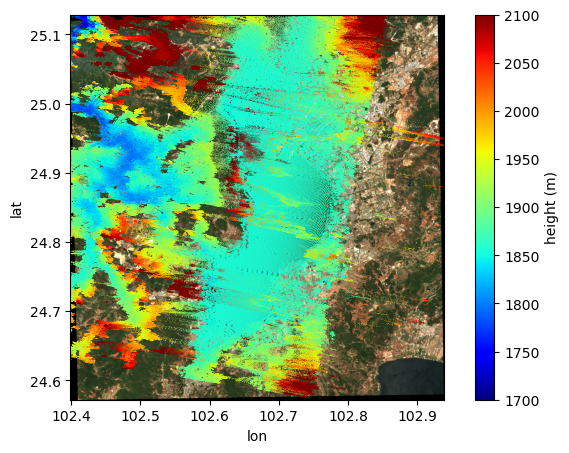

In [5]:
# mask = np.where(pixc_nc.geolocation_qual <= 4096)
# print(mask[0].shape)
fig, ax = plt.subplots(figsize=(8,5))
scat = ax.scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_nc.height,
           s=0.1, edgecolor='none', cmap='jet', clim=(1700, 2100))
# dianchi_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=2)
imgShow(rsimg_io.array, extent=rsimg_io.geoextent, ax=ax)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
fig.colorbar(scat).set_label('height (m)')


#### 2. Select pixel cloud data of the given lake region.

In [6]:
lat = pixc_nc['latitude'].values
lon = pixc_nc['longitude'].values
heights = pixc_nc['height'].values
pixel_area = pixc_nc['pixel_area'].values
## corrections
geoid = pixc_nc['geoid'].values
load_tide = pixc_nc['load_tide_fes'].values
pole_tide = pixc_nc['pole_tide'].values
solid_earth_tide = pixc_nc['solid_earth_tide'].values
heights = heights - (geoid + load_tide + pole_tide + solid_earth_tide)   ### egm2008 height
## convert to shapely.Point object.
points = list(zip(lon, lat))
points = [Point(point) for point in points]


In [7]:
mask_vec = dianchi_gpd.geometry[0].contains(np.array(points))
lon_vec = np.ma.masked_array(lon, mask=~mask_vec, fill_value=np.nan)
lat_vec = np.ma.masked_array(lat, mask=~mask_vec, fill_value=np.nan)
heights_vec = np.ma.masked_array(heights, mask=~mask_vec, fill_value=np.nan)


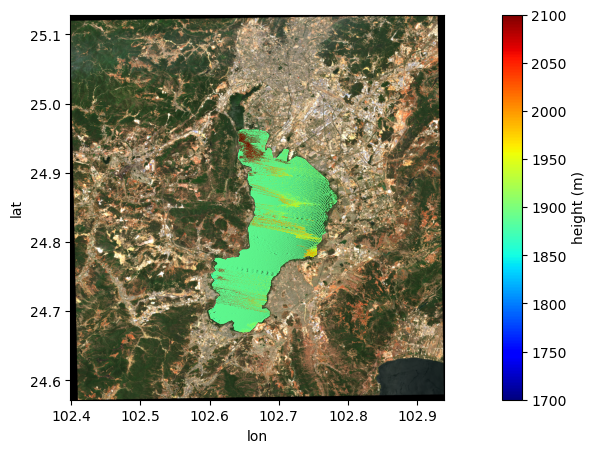

In [8]:
rsimg_io = readTiff(path_img)
crs='EPSG:4326'
fig, ax = plt.subplots(figsize=(15,5))
scat = ax.scatter(x=lon_vec[~lon_vec.mask], y=lat_vec[~lat_vec.mask], \
                  c=heights_vec[~heights_vec.mask], s=0.1, edgecolor='none', cmap='jet', clim=(1700, 2100))
# dianchi_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=2)
imgShow(rsimg_io.array, extent=rsimg_io.geoextent, ax=ax)
ax.set_xlabel('lon'); ax.set_ylabel('lat')
fig.colorbar(scat).set_label('height (m)')


#### 3. Data filtering using IQR method.

In [9]:
heights_vec_IQR, IQR = IQR_filter(heights_vec.filled(np.nan))
heights_vec_IQR.mask = heights_vec_IQR.mask | heights_vec.mask
while IQR > 0.3:
    print(IQR)
    heights_vec_IQR_mask = heights_vec_IQR.mask
    heights_vec_IQR, IQR = IQR_filter(heights_vec_IQR.filled(np.nan))
    heights_vec_IQR.mask = heights_vec_IQR.mask | heights_vec_IQR_mask
print(IQR)


33.49700927734375
0.1837158203125


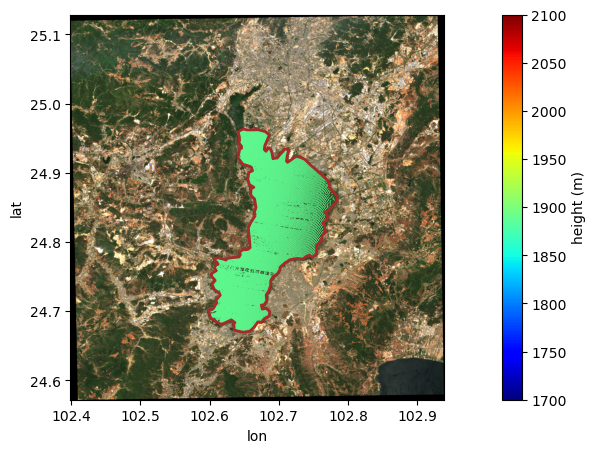

In [10]:
rsimg_io = readTiff(path_img)
crs='EPSG:4326'
fig, ax = plt.subplots(figsize=(15,5))
scat = ax.scatter(x=lon[~heights_vec_IQR.mask], y=lat[~heights_vec_IQR.mask], \
                  c=heights[~heights_vec_IQR.mask], s=0.1, edgecolor='none', cmap='jet', clim=(1700, 2100))
dianchi_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=2)
imgShow(rsimg_io.array, extent=rsimg_io.geoextent, ax=ax)
ax.set_xlabel('lon'); ax.set_ylabel('lat')
fig.colorbar(scat).set_label('height (m)')


#### 4.calculate the average and standard deviation values of the height. 

In [11]:
### simple average and std of the heights
# height_mean = np.nanmean(heights_vec_IQR)
# height_std = np.nanstd(heights_vec_IQR)
# print(height_mean, height_std)


In [12]:
### area averaged heights
pixel_height_ = heights[~heights_vec_IQR.mask]
pixel_area_ = pixel_area[~heights_vec_IQR.mask]
def area_averaged(heights, areas):
  pixel_heights_sum = np.sum(areas*heights)
  pixel_AreaAveraged_height = pixel_heights_sum/np.sum(pixel_area_)
  weighted_var = [(pixel_height_[i] - pixel_AreaAveraged_height)**2*pixel_area_[i] for i in range(pixel_height_.shape[0])]
  weighted_var_sum = np.sum(weighted_var)
  weighted_std = np.sqrt(weighted_var_sum/sum(pixel_area_))
  return pixel_AreaAveraged_height, weighted_std

pixel_AreaAveraged_height, weighted_dev = area_averaged(heights=pixel_height_, areas=pixel_area_)
print('Area averaged height:', pixel_AreaAveraged_height)
print('Area averaged deviation: ', weighted_dev)


Area averaged height: 1887.7064
Area averaged deviation:  0.11708776845338732


#### 5. time-series processing for the pixc data.

In [13]:
## get acquisition time information
date_data = [path.split('_')[-4][0:8] for path in paths_file]
date_data = [date[0:4]+'-'+date[4:6]+'-'+date[6:8] for date in date_data]
print(date_data)


['2024-01-05', '2024-01-26', '2024-02-16', '2024-03-08', '2024-03-29', '2024-04-19', '2024-05-10', '2024-05-30', '2024-06-20']


In [ ]:
heights_dianchi = {}
pixel_area_dianchi = {}
heights_geoid_dianchi = {}
for i, path in enumerate(paths_file):
  print(i, path)
  date = date_data[i]
  pixc_nc = xr.open_dataset(path, group='pixel_cloud')
  ## Extract lat, lon and heights for the .nc data.
  lat, lon, heights = pixc_nc['latitude'].values, pixc_nc['longitude'].values, pixc_nc['height'].values
  pixel_area = pixc_nc['pixel_area'].values
  heights_geoid = pixc_nc['geoid'].values
  ### Select the point cloud of the lake.
  points = [Point(point) for point in list(zip(lon, lat))]
  points_vec_mask = dianchi_gpd.geometry[0].contains(np.array(points))
  lon_vec = np.ma.masked_array(lon, mask=~points_vec_mask, fill_value=np.nan)
  lat_vec = np.ma.masked_array(lat, mask=~points_vec_mask, fill_value=np.nan)
  heights_vec = np.ma.masked_array(heights, mask=~points_vec_mask, fill_value=np.nan)
  ### Select the valid point cloud of the lake.
  heights_vec_IQR, IQR = IQR_filter(heights_vec.filled(np.nan))
  heights_vec_IQR.mask = heights_vec_IQR.mask | heights_vec.mask
  while IQR > 0.3:
    heights_vec_IQR_mask = heights_vec_IQR.mask
    heights_vec_IQR, IQR = IQR_filter(heights_vec_IQR.filled(np.nan))
    heights_vec_IQR.mask = heights_vec_IQR.mask | heights_vec_IQR_mask
  pixel_area_dianchi[date] = pixel_area
  heights_dianchi[date] = heights_vec_IQR
  heights_geoid_dianchi[date] = heights_geoid


0 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_009_049_198L_20240105T211648_20240105T211659_PGC0_01.nc
1 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_010_049_198L_20240126T180154_20240126T180205_PIC0_01.nc
2 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_011_049_198L_20240216T144659_20240216T144710_PIC0_01.nc
3 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_012_049_198L_20240308T113203_20240308T113214_PIC0_01.nc
4 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_013_049_198L_20240329T081707_20240329T081718_PIC0_01.nc
5 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_014_049_198L_20240419T050213_20240419T050224_PIC0_01.nc
6 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_015_049_198L_20240510T014716_20240510T014727_PIC0_01.nc
7 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_016_049_198L_20240530T223221_20240530T223232_PIC0_01.nc
8 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_017_049_198L_20240620T191726_20240620T191737_PIC0_01.nc


In [29]:
heights_dianchi_average, heights_dianchi_std = {}, {}
### 1. Normal average and std value of heights
# for date in heights_dianchi:
#   heights_dianchi_mean[date] = np.nanmean(heights_dianchi[date])
#   heights_dianchi_std[date] = np.nanstd(heights_dianchi[date])
### 2. area averaged and std value of heights
for date in heights_dianchi:
  pixel_height_ = heights_dianchi[date][~heights_dianchi[date].mask] - heights_geoid_dianchi[date][~heights_dianchi[date].mask]
  pixel_area_ = pixel_area_dianchi[date][~heights_dianchi[date].mask]
  pixel_AreaAveraged_height, weighted_std = area_averaged(heights=pixel_height_, areas=pixel_area_)
  heights_dianchi_average[date] = pixel_AreaAveraged_height
  heights_dianchi_std[date] = weighted_std


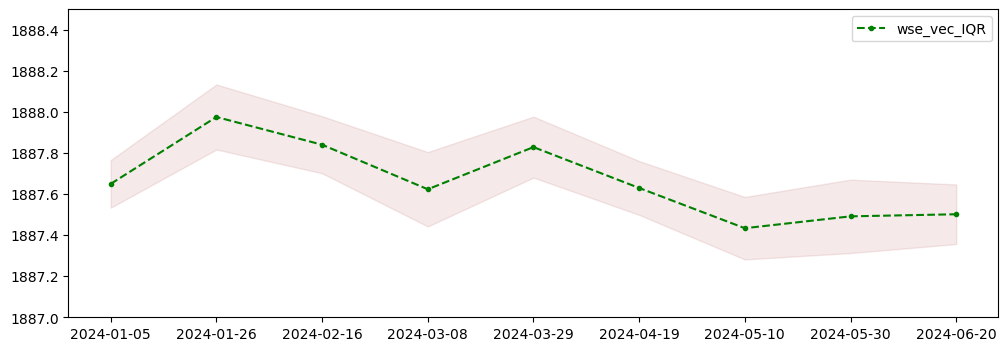

In [30]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(heights_dianchi_average.keys(), heights_dianchi_average.values(), '--.', color='green', label='wse_vec_IQR')
ax.fill_between(date_data, np.array([*heights_dianchi_average.values()]) - np.array([*heights_dianchi_std.values()]), \
                np.array([*heights_dianchi_average.values()]) + np.array([*heights_dianchi_std.values()]), color='Brown', alpha=0.1)
ax.set_ylim([1887, 1888.5])
ax.legend()
